In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import os

class cell_migration3:
    
    def __init__(self, L ,W, H, N0, C0, Uc, Un, Dc, Dn, Qcb0, Qcd0, Qn, A0, dx, dt):
        #W = 10    #width
        #L = 850   #length
        #H = 17    #height
        L_ = 850
        V = L_*H*W
        M = 20     #number of tubes
        L1= V/(M*W*H)
        self.eps = 0.01
        
        self.d1 = Dc/Dn
        self.d2 = 0 #Un*L/Dc
        self.d3 = Qn*C0*L**2/Dn
        self.e1 = Uc*L/Dc
        self.e2 = A0*N0/Dc
        self.e3 = Qcb0*N0*C0*L**2/Dc
        self.e4 = Qcd0*L**2/(Dc*N0)
        
        self.l_ = L/L_ #L = L^
        self.l1 = L1/L_
        
        self.dx = dx
        self.dt = dt
         
        self.a = int((self.l_+self.l1)/dx)#end of the real tube
        self.b = int(1/dt) # n of step for iteration -> time
        
        self.e = int(self.l_/dx) #end of our experiment: end of real+img. tube
        
        #concentration of cell
        self.c = pd.DataFrame(np.zeros([self.a+1, self.b+1]))
        self.c.iloc[:,0] = 0
        self.c.iloc[0,1:] = 1
        
        #concentration of nutrient 
        self.n = pd.DataFrame(np.zeros([self.a+1, self.b+1]))
        self.n.iloc[:int(1/dx),0] = 0
        self.n.iloc[0,:] = 0
        self.n.iloc[int(1/dx):,:] = 1     
        
        
    def f1(self,i):
        f = self.e1*self.dt/(2*self.dx) - self.dt/self.dx**2 - self.e2*self.dt/(4*self.dx**2) \
            *(self.n.iloc[:,i].shift(-1) - self.n.iloc[:,i].shift(1))
        return f

    def g1(self,i):
        g = (1+2*self.dt/self.dx**2 - self.e2*self.dt/self.dx**2 * \
            (self.n.iloc[:,i].shift(-1) -2*self.n.iloc[:,i] + self.n.iloc[:,i].shift(1)) \
            - self.e3*self.dt*self.n.iloc[:,i]*(1-self.c.iloc[:,i]) + self.e4*self.dt/(self.c.iloc[:,i]+self.eps))
        return g

    def k1(self,i):
        k = (-self.e1*self.dt/(2*self.dx) -self.dt/self.dx**2 + self.e2*self.dt/(4*self.dx**2)\
             *(self.n.iloc[:,i].shift(-1) - self.n.iloc[:,i].shift(1)))
        return k
    # x => 1

    def f2(self,i):
        f =self.e1*self.dt/(2*self.dx) - self.dt/self.dx**2 
        return f

    def g2(self,i):
        f = 1 + 2*self.dt/self.dx**2 + self.e3*(1-self.c.iloc[self.e+1:,i]) + self.e4*self.dt/(1+self.eps) 
        return f

    def k2(self,i):
        f = -self.e1*self.dt/(2*self.dx) - self.dt/self.dx**2
        return f

    def n_new(self,i):
        phi = self.d3 * self.dx**2 * self.c.values[1:self.e+1,i] + 2
        A = (-np.diag(phi) + np.diag(np.ones(self.e-1),1) + np.diag(np.ones(self.e-1),-1))
        A[-1] = np.append(np.zeros(self.e-1),1)
        return np.linalg.solve(A, np.append(np.zeros(self.e-1),1))

    def n_new2(self,i):
        phi = self.d3 * self.dx**2 * self.c + 2
        A = (-np.diag(phi) + np.diag(np.ones(self.e-1),1) + np.diag(np.ones(self.e-1),-1))
        A[-1] = np.append(np.zeros(self.e-1),1)
        return np.linalg.solve(A, np.append(np.zeros(self.e-1),1))

    def n_new3(self,i):
        phi = self.d3 * self.dx**2 * self.c.values[1:self.e+1,i] + 2
        A = (-np.diag(phi) + np.diag(np.ones(self.e-1),1) + np.diag(np.ones(self.e-1),-1))
        A[-1] = np.append(np.zeros(self.e-1),1)
        return A

    def new_c(self,j):
        f_diag = self.f1(j)
        f_diag[self.e] = (self.e1*self.dt/(2*self.dx) - self.dt/self.dx**2 - self.e2*self.dt/(4*self.dx**2)*(self.n.iloc[self.e+1,j] - self.n.iloc[self.e-1,j]))
        f_diag[self.e+1:] = self.f2(j)

        #g1
        g_diag = self.g1(j)
        g_diag[self.e] = (1+2*self.dt/self.dx**2 - self.e2*self.dt/self.dx**2\
                          *(self.n.iloc[self.e+1,j] - 2*self.n.iloc[self.e,j] + self.n.iloc[self.e-1,j]) \
                          - self.e3*self.dt*self.n.iloc[self.e,j]*(1-self.c.iloc[self.e,j]) + self.e4*self.dt/(self.n.iloc[self.e,j]+self.eps))
        g_diag[self.e+1:] = self.g2(j)
        g_diag[self.a+1] = 1

        #k1
        k_diag = self.k1(j).shift(1)
        k_diag[self.e] = (-self.e1*self.dt/(2*self.dx) -self.dt/self.dx**2 + self.e2*self.dt/(4*self.dx**2)*(self.n.iloc[self.e+1,j] - self.n.iloc[self.e-1,j])) 
        k_diag[self.e+1:] = self.k2(j)
        k_diag[self.a+1] = 0

        c_df_test = pd.DataFrame(np.zeros(self.c.shape))
        c_df_test = c_df_test + self.c.values
        c_test = c_df_test.iloc[1:,j-1].values
        c_test[0] = c_test[0] - self.k2(j)
        c_test = np.append(c_test,0)

        U = np.diag(g_diag.dropna()) + np.diag(k_diag.dropna(),-1) + np.diag(f_diag.dropna(),1)
        U[self.a, self.a-2] = -1

        return np.linalg.solve(U, c_test)[:-1]
    
    def compute_all(self):
        for cq in range(0,self.b):
            self.n.iloc[1:self.e+1,cq+1] = self.n_new(cq)[:]
            self.c.iloc[1:,cq+1] = self.new_c(cq)[:]

    def compute_all_all(self):
        comp = self.compute_all(var1,var2)
        return com.sum()
    
    def avg_channel(self):
        return self.c.values[1:self.e,1:self.a].sum() / (self.e*(self.a))
    
    def avg_entering(self):
        return self.c.values[self.e,1:self.a].sum() / (self.a)
    
    def plotting_conc(self,name):
        fig_n = sns.lineplot(x = np.tile(np.arange(0,cm.a+1),cm.b+1), y = pd.melt(cm.n).value, hue = np.repeat(np.arange(0,cm.a+1),cm.b+1),palette = "Blues")

        fig_c = sns.lineplot(x = np.tile(np.arange(0,cm.a+1),cm.b+1), y = pd.melt(cm.c).value, hue = np.repeat(np.arange(0,cm.a+1),cm.b+1),palette = "Blues")

        plt.xlabel("x")
        plt.ylabel("concentration")
        plt.title("Cell & Nutrient Concentration")
        fig_n.legend_.remove()
        
        plt.plot(np.arange(self.a), np.zeros(self.a)+self.avg_channel(), linestyle='dashed')
        plt.plot(np.arange(self.a), np.zeros(self.a)+self.avg_entering(), linestyle='-.')
        
        #plt.text(self.a+self.b-9,self.avg_channel()-0.1, 'Avg # of Cells in a Channel')
        #plt.text(self.a+self.b-9,self.avg_entering()-0.1, 'Avg # of Cells entering')
        plt.savefig(name)
        
    def get_n(self):
        return self.n

    def get_c(self):
        return self.c


In [9]:
L = 100   #length

W = 10    #width
L_ = 850
H = 17    #height
# V = L*H*W


'''
is it has to be L_ or L? for the V
'''
V = L_*H*W 
M = 20    #number of tubes

N0 = 1.204 #mol/um^3
C0 = 5*10**-4 #cells/um^2
Uc = 2 #um/min
Un = 0
Dc = 1
Dn = 1.8 #um^2/min
Qcb0 = 1
Qcd0 = 1
Qn = 1
A0 = 1

d1 = Dc/Dn
d2 = Un*L/Dc # = 0
d3 = Qn*C0*L**2 / Dn

e1 = Uc*L/Dc
e2 = A0*N0/Dc
e3 = Qcb0*N0*C0*L**2/Dc
e4 = Qcd0*L**2/Dc/N0
L1 = V/(M*W*H)
l_ = L/L_
l1 = L1/L_

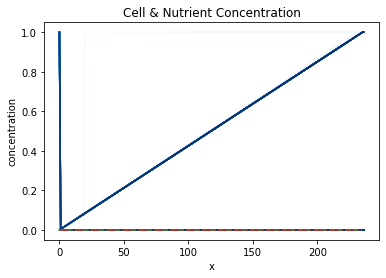

In [11]:
dx = 0.05
dt = 0.05

cm = cell_migration3(10000, W, H, N0, C0, Uc, Un, Dc, Dn, Qcb0, Qcd0, Qn, A0, dx, dt)

cm.compute_all()
cm.c.round(4)
cm.plotting_conc('hi')
